In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Filtering out the warnings after Cell Execution

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### Reading data

In [4]:
dataset = pd.read_csv('/content/1805234.csv')
df = dataset.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   business_code           50000 non-null  object 
 1   cust_number             50000 non-null  object 
 2   name_customer           50000 non-null  object 
 3   clear_date              46387 non-null  object 
 4   buisness_year           50000 non-null  float64
 5   doc_id                  50000 non-null  float64
 6   posting_date            50000 non-null  object 
 7   document_create_date    50000 non-null  int64  
 8   document_create_date.1  50000 non-null  int64  
 9   due_in_date             50000 non-null  float64
 10  invoice_currency        50000 non-null  object 
 11  document type           50000 non-null  object 
 12  posting_id              50000 non-null  float64
 13  area_business           0 non-null      float64
 14  total_open_amount       50000 non-null

In [5]:
df.head(5)

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200732755,KROGER us,2019-08-19 00:00:00,2019.0,1.929686e+09,2019-08-02,20190731,20190802,20190817.0,USD,RV,1.0,NaN,17519.05,20190802.0,NAA8,1.929686e+09,0
1,U001,0200782669,SYGMA co,2019-07-24 00:00:00,2019.0,1.929570e+09,2019-07-03,20190703,20190703,20190723.0,USD,RV,1.0,NaN,20808.05,20190703.0,NAD1,1.929570e+09,0
2,U001,0200418007,AM us,2019-04-03 00:00:00,2019.0,1.928973e+09,2019-03-19,20190315,20190319,20190403.0,USD,RV,1.0,NaN,4825.51,20190319.0,NAA8,1.928973e+09,0
3,U001,0200769623,WAL-MAR foundation,2019-06-20 00:00:00,2019.0,1.929456e+09,2019-06-09,20190607,20190609,20190624.0,USD,RV,1.0,NaN,68105.13,20190609.0,NAH4,1.929456e+09,0
4,U001,0200707822,PUBLI foundation,2019-08-05 00:00:00,2019.0,1.929642e+09,2019-07-20,20190720,20190720,20190804.0,USD,RV,1.0,NaN,236113.57,20190720.0,NAA8,1.929642e+09,0


### Meaning of the columns

* business_code - company code of the account
* cust_number - customer number given to all the customers of the Account
* name_customer - name of the customer
* clear_date - The date on which the customer clears an invoice, or in simple terms, they make the full payment
* business_year -  year in which the business was made
* doc_id - It is also an unique identifier of an invoice is a primary key for acct_doc_header table
* posting_date - date on which document is posted on ERP
* document_create_date - The date on which the invoice document was created
* due_in_date - The date on which the customer is expected to clear an invoice
* invoice_currency - The currency of the invoice amount in the document for the invoice
* document_type - It represents the type of document, eg D1 represents Invoice
* posting_id - key indicator to identify whether an AR item is invoice, deduction, credit memo based on its value. Appicable for SAP ERP
* area_business - Business area in sap is defined as an organisationalarea within the financial accounting module
* total_open_amount - The amount that is yet to be paid for that invoice
* baseline_create_date - The date on which invoice was created
* cust_payment_terms - Business terms and agreements between customers and accounts on discounts and days of payment
* invoice_id - Unique number assigned when a seller creates an Invoice
* isOpen - indicator of whether an invoice is open or closed. isOpen = 1, means the invoice is open

In [6]:
df.shape

(50000, 19)

In [7]:
# getting the number of null values in each column
df.isnull().sum()

business_code                 0
cust_number                   0
name_customer                 0
clear_date                 3613
buisness_year                 0
doc_id                        0
posting_date                  0
document_create_date          0
document_create_date.1        0
due_in_date                   0
invoice_currency              0
document type                 0
posting_id                    0
area_business             50000
total_open_amount             0
baseline_create_date          0
cust_payment_terms            0
invoice_id                    8
isOpen                        0
dtype: int64

In [8]:
# the number of unique values in each column
df.nunique()

business_code                 6
cust_number                1470
name_customer              4333
clear_date                  402
buisness_year                 2
doc_id                    50000
posting_date                499
document_create_date        505
document_create_date.1      499
due_in_date                 538
invoice_currency              2
document type                 2
posting_id                    1
area_business                 0
total_open_amount         45250
baseline_create_date        505
cust_payment_terms           75
invoice_id                49992
isOpen                        2
dtype: int64

In [9]:
# Remove Rows where "invoice id" is 'null'
df = df.dropna(subset=['invoice_id'], axis = 0)
len(df['invoice_id'].unique())

49992

In [10]:
# Remove completely Null columns
null_cols=[]
def rem_comp_null_cols(data):
    for col in data.columns:
        if data[col].isnull().sum() == len(data.index):
            null_cols.append(col)
    return null_cols

print(rem_comp_null_cols(df))
df.drop(null_cols, axis = 1, inplace=True)

['area_business']


In [11]:
# Remove duplicate columns
col_names = set()
def duplicates_cols(df):
    cols = df.columns
    
    for i in range(0, len(cols)):
        for j in range(i + 1, len(cols)):
            if df[cols[i]].equals(df[cols[j]]) == True:
              col_names.add(cols[i])
    return list(col_names)

print(duplicates_cols(df))
df.drop(col_names, axis=1, inplace=True)

['doc_id']


In [12]:
# Remove constant columns
cols = []
def rem_const_cols(data):
    for col in data.columns:
        if data[col].nunique() == 1:
            cols.append(col)
    return cols
print(rem_const_cols(df))
df.drop(cols, axis=1, inplace=True) # dropping the values

['document type', 'posting_id']


In [13]:
# the "document_create_date.1" column is normalised, so dropping "document_create_date"
df.drop("document_create_date", axis=1, inplace=True)

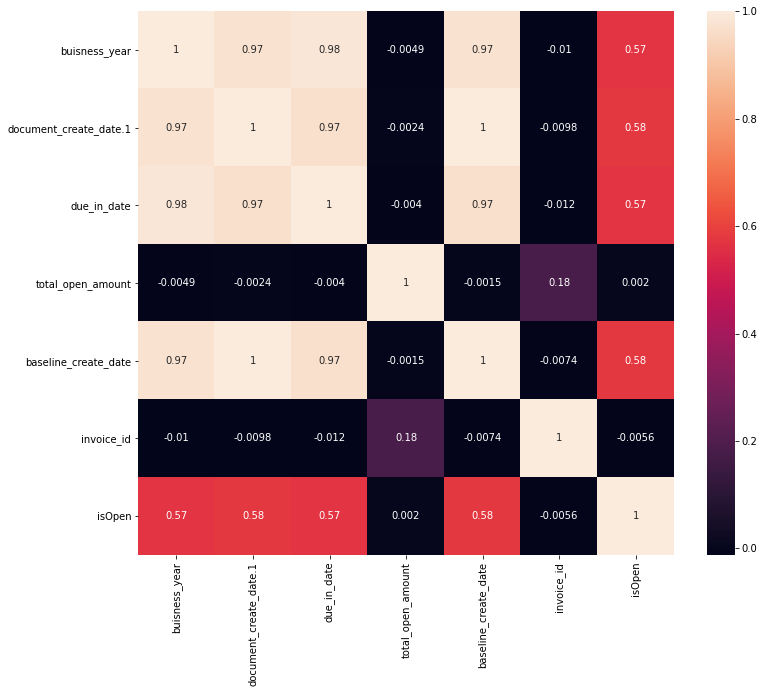

In [14]:
# visualising the correlation matrix using heatmap
plt.figure(figsize = (12,10))
sns.heatmap(df.corr(), annot=True)

### Converting appropriate columns into date-time format

In [15]:
#converting business_year from float64 to int64.
df['buisness_year'] = df['buisness_year'].astype(np.int64)

In [16]:
#changing the format of clear_date column.
df['clear_date'] = pd.to_datetime(df['clear_date'])

In [17]:
#changing the format of posting_date column.
df['posting_date'] =  pd.to_datetime(df['posting_date'])

In [18]:
#changing the due_in_date column format into datetime.
df['due_in_date'] = df['due_in_date'].astype(np.int64)
df['due_in_date'] = df['due_in_date'].astype('str')
df['due_in_date'] =  pd.to_datetime(df['due_in_date'])

In [19]:
#changing the document_create_date.1 column format into datetime.
df['document_create_date.1'] = df['document_create_date.1'].astype('str')
df['document_create_date.1'] =  pd.to_datetime(df['document_create_date.1'])

In [20]:
#changing the baseline_create_date column format into datetime.
df['baseline_create_date'] = df['baseline_create_date'].astype(np.int64)
df['baseline_create_date'] = df['baseline_create_date'].astype('str')
df['baseline_create_date'] =  pd.to_datetime(df['baseline_create_date'])

In [21]:
#unique values in columns
unique = df.nunique().to_frame()
unique.columns=['unique_values']

#null value count in columns
null_values = df.isnull().sum().to_frame()
null_values.columns = ['null_value_count']

#datatype of every feature
datatype = df.dtypes.to_frame()
datatype.columns = ['data types']

pd.concat([unique, null_values, datatype], join = 'outer', axis = 1) 

,unique_values,null_value_count,data types
business_code,6,0,object
cust_number,1470,0,object
name_customer,4329,0,object
clear_date,402,3613,datetime64[ns]
buisness_year,2,0,int64
posting_date,499,0,datetime64[ns]
document_create_date.1,499,0,datetime64[ns]
due_in_date,538,0,datetime64[ns]
invoice_currency,2,0,object
total_open_amount,45243,0,float64


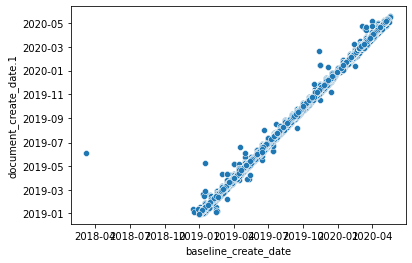

In [22]:
# visualising relationship between 'baseline_create_date' and 'document_create_date.1'
sns.scatterplot(df['baseline_create_date'], df['document_create_date.1'])

We can observe from scatter plot that majority of data is equal.

In [23]:
# seeing what percent of data in 'baseline_create_date' and 'document_create_date.1' are equal
len(df[df['baseline_create_date'] == df['document_create_date.1']].index) / len(df.index) * 100

89.04624739958393

Nearly 89% data in 'baseline_create_date' and 'document_create_date.1' are equal. so removing 'baseline_create_date'

In [24]:
df.drop('baseline_create_date', axis=1, inplace=True)

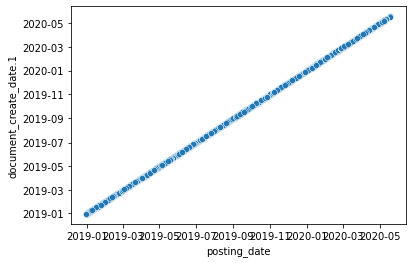

In [25]:
# visualising relationship between 'baseline_create_date' and 'document_create_date.1'
sns.scatterplot(df['posting_date'], df['document_create_date.1'])

Both columns of 'posting_date' and 'document_create_date.1' are equal.So, removing "posting date"

In [26]:
df.drop('posting_date', axis=1, inplace=True)

In [27]:
# Changing dtype of "invoice_id" to int64
df['invoice_id'] = df['invoice_id'].astype(np.int64)

In [28]:
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,document_create_date.1,due_in_date,invoice_currency,total_open_amount,cust_payment_terms,invoice_id,isOpen
0,U001,0200732755,KROGER us,2019-08-19,2019,2019-08-02,2019-08-17,USD,17519.05,NAA8,1929686233,0
1,U001,0200782669,SYGMA co,2019-07-24,2019,2019-07-03,2019-07-23,USD,20808.05,NAD1,1929570192,0
2,U001,0200418007,AM us,2019-04-03,2019,2019-03-19,2019-04-03,USD,4825.51,NAA8,1928972570,0
3,U001,0200769623,WAL-MAR foundation,2019-06-20,2019,2019-06-09,2019-06-24,USD,68105.13,NAH4,1929456050,0
4,U001,0200707822,PUBLI foundation,2019-08-05,2019,2019-07-20,2019-08-04,USD,236113.57,NAA8,1929641854,0


In [29]:
df.describe()

,buisness_year,total_open_amount,invoice_id,isOpen
count,49992.000000,4.999200e+04,4.999200e+04,49992.000000
mean,2019.193051,3.242437e+04,2.011173e+09,0.072272
std,0.394697,3.985552e+04,2.764657e+08,0.258940
min,2019.000000,4.400000e-01,1.928483e+09,0.000000
25%,2019.000000,4.892340e+03,1.929233e+09,0.000000
50%,2019.000000,1.747514e+04,1.929796e+09,0.000000
75%,2019.000000,4.723226e+04,1.930382e+09,0.000000
max,2020.000000,1.501474e+06,2.960635e+09,1.000000


In [30]:
# Checking anamolies
# document create date cannot occur after due in date
# clear date cannot be less than document create date
print(df[df['document_create_date.1'] > df['due_in_date']].shape)
print(df[df['clear_date'] < df['document_create_date.1']].shape)
print(df[df['total_open_amount'] < 0].shape)

(140, 12)
(0, 12)
(0, 12)


In [31]:
# removing anamolies
df.drop(df[df['document_create_date.1'] > df['due_in_date']].index, inplace = True)
df.shape

(49852, 12)

### Splitting the dataset into Train - Test set on the basis of 'clear_date'' column
* Train set contains data whose clear date is not null means payment have been done.
* Test set contains data whose clear date is null means payment has not been done.

In [32]:
train_val1_val2 = df[df['clear_date'].notnull()].copy()
test = df[df['clear_date'].isnull()].copy()

print(f"Train-val1-val2 shape: {train_val1_val2.shape}\nTest shape: {test.shape}")

Train-val1-val2 shape: (46257, 12)
Test shape: (3595, 12)


In [33]:
# Removing constant columns
cols = []
def rem_const_cols(data):
    for col in data.columns:
        if data[col].nunique() == 1:
            cols.append(col) # the ist which sotres the same column
    return cols
print(rem_const_cols(train_val1_val2))
train_val1_val2.drop(cols, axis=1, inplace=True) # dropping the constant columns here

['isOpen']


In [34]:
# sorting the data on the basis of 'document_create_date.1'
train_val1_val2.sort_values(by = ['document_create_date.1'], ascending=True, inplace=True)
train_val1_v2 = train_val1_val2.reset_index(drop=True)
train_val1_val2.head(5)

,business_code,cust_number,name_customer,clear_date,buisness_year,document_create_date.1,due_in_date,invoice_currency,total_open_amount,cust_payment_terms,invoice_id
7293,U001,0200726979,BJ'S,2019-01-15,2019,2018-12-30,2019-01-14,USD,42.04,NAA8,1928540633
38373,U001,0200706844,WINC llc,2019-01-14,2019,2018-12-30,2019-01-14,USD,14235.96,NAA8,1928521038
1779,U001,0200772670,ASSOCIAT us,2019-01-14,2019,2018-12-30,2019-01-14,USD,351.20,NAU5,1928542661
16153,U001,0200769623,WAL-MAR llc,2019-01-09,2019,2018-12-30,2019-01-14,USD,6145.65,NAH4,1928540562
14578,U001,0200769623,WAL-MAR corporation,2019-01-10,2019,2018-12-30,2019-01-14,USD,8730.88,NAH4,1928538220


In [35]:
#Creating Target variable column
# creating the 'delay' column which means how late the amount was cleared 
train_val1_val2['delay'] = (train_val1_val2['clear_date'] - train_val1_val2['due_in_date']).dt.days
train_val1_val2.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,document_create_date.1,due_in_date,invoice_currency,total_open_amount,cust_payment_terms,invoice_id,delay
7293,U001,0200726979,BJ'S,2019-01-15,2019,2018-12-30,2019-01-14,USD,42.04,NAA8,1928540633,1
38373,U001,0200706844,WINC llc,2019-01-14,2019,2018-12-30,2019-01-14,USD,14235.96,NAA8,1928521038,0
1779,U001,0200772670,ASSOCIAT us,2019-01-14,2019,2018-12-30,2019-01-14,USD,351.20,NAU5,1928542661,0
16153,U001,0200769623,WAL-MAR llc,2019-01-09,2019,2018-12-30,2019-01-14,USD,6145.65,NAH4,1928540562,-5
14578,U001,0200769623,WAL-MAR corporation,2019-01-10,2019,2018-12-30,2019-01-14,USD,8730.88,NAH4,1928538220,-4


In [36]:
target_dataset = train_val1_val2['delay'] # we need to predict delay
feature_dataset = train_val1_val2.drop('delay', axis = 1)

### Splitting in train set, validation set-1 and validation set-2

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(feature_dataset, target_dataset, test_size = 0.3, random_state = 42, shuffle = False)

X_val1, X_val2, y_val1, y_val2 = train_test_split(X_val, y_val, test_size = 0.5, random_state = 10, shuffle = False)

# printing the shape of each set i.e. train, val1 and val2
print(f"X_train shape: {X_train.shape}\ty_train shape: {y_train.shape}\nX_val1 shape: {X_val1.shape}\ty_val1 shape: {y_val1.shape}\nX_val2 shape: {X_val2.shape}\ty_val2 shape: {y_val2.shape}")

X_train shape: (32379, 11)	y_train shape: (32379,)
X_val1 shape: (6939, 11)	y_val1 shape: (6939,)
X_val2 shape: (6939, 11)	y_val2 shape: (6939,)


In [38]:
# Creating Training set for EDA, Visualization, Feature engineering
Train = pd.concat([X_train,y_train],axis=1) # the training dataset
Val1 = pd.concat([X_val1, y_val1], axis=1) # the validation datset, val1
Val2 = pd.concat([X_val2, y_val2], axis=1) # the validation datset, val2

In [39]:
Train.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,document_create_date.1,due_in_date,invoice_currency,total_open_amount,cust_payment_terms,invoice_id,delay
7293,U001,0200726979,BJ'S,2019-01-15,2019,2018-12-30,2019-01-14,USD,42.04,NAA8,1928540633,1
38373,U001,0200706844,WINC llc,2019-01-14,2019,2018-12-30,2019-01-14,USD,14235.96,NAA8,1928521038,0
1779,U001,0200772670,ASSOCIAT us,2019-01-14,2019,2018-12-30,2019-01-14,USD,351.20,NAU5,1928542661,0
16153,U001,0200769623,WAL-MAR llc,2019-01-09,2019,2018-12-30,2019-01-14,USD,6145.65,NAH4,1928540562,-5
14578,U001,0200769623,WAL-MAR corporation,2019-01-10,2019,2018-12-30,2019-01-14,USD,8730.88,NAH4,1928538220,-4


### Exploratory Data Analysis

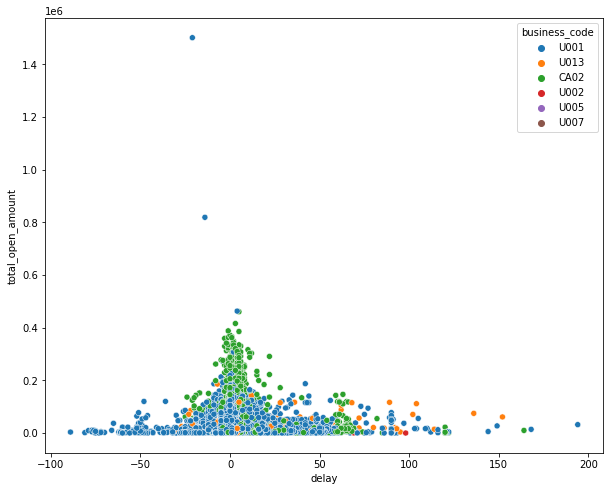

In [40]:
# visualing relationship between "delay" and "total open amount" by "business_code"

plt.figure(figsize= (10,8))
sns.scatterplot(Train['delay'], Train['total_open_amount'], data = Train, hue = 'business_code')

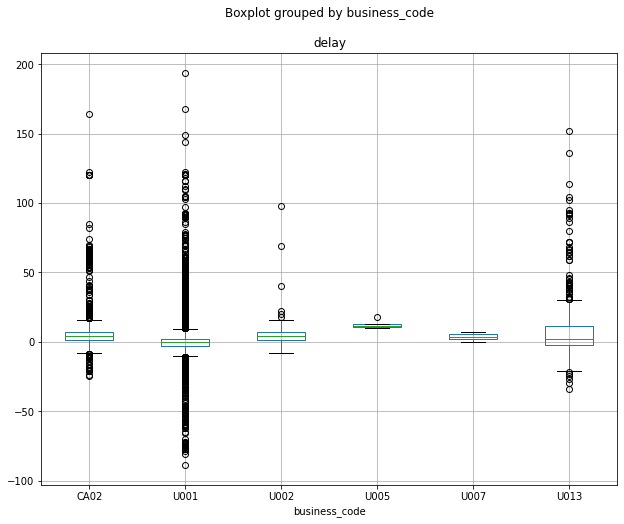

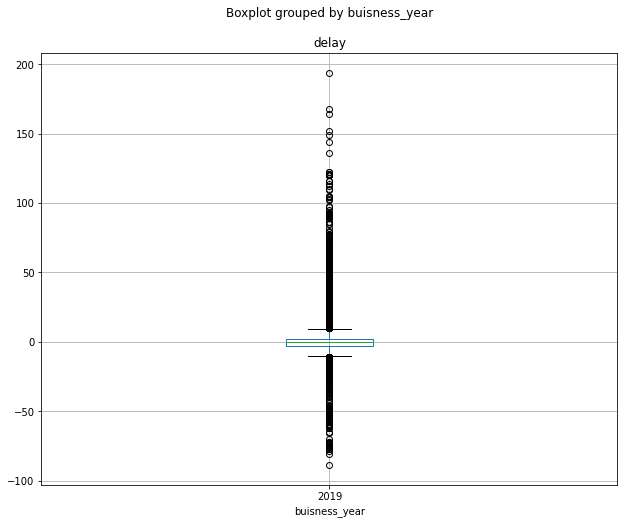

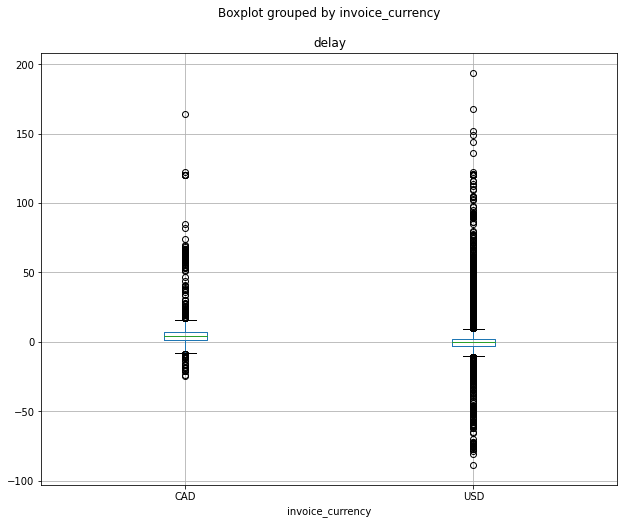

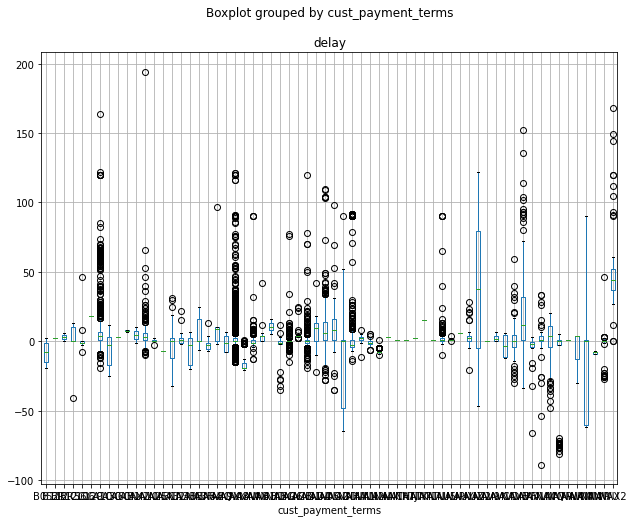

In [41]:
fig, ax = plt.subplots(figsize = (10, 8))
plt.suptitle('')
Train.boxplot(column = ['delay'], by = 'business_code', ax = ax)
plt.show()

fig, ax = plt.subplots(figsize = (10, 8))
plt.suptitle('')
Train.boxplot(column = ['delay'], by = 'buisness_year', ax = ax)
plt.show()

fig, ax = plt.subplots(figsize =(10, 8))
plt.suptitle('')
Train.boxplot(column = ['delay'], by = 'invoice_currency', ax = ax)
plt.show()

fig, ax = plt.subplots(figsize = (10, 8))
plt.suptitle('')
Train.boxplot(column = ['delay'], by = 'cust_payment_terms', ax = ax)
plt.show()

In [42]:
# dropping the less important features
# dropping the 'business_year' beacause the info given by it is already provided by the date columns
Train.drop(['buisness_year', 'invoice_id'], axis = 1, inplace = True)
Val1.drop(['buisness_year', 'invoice_id'], axis = 1, inplace = True)
Val2.drop(['buisness_year', 'invoice_id'], axis = 1, inplace = True)

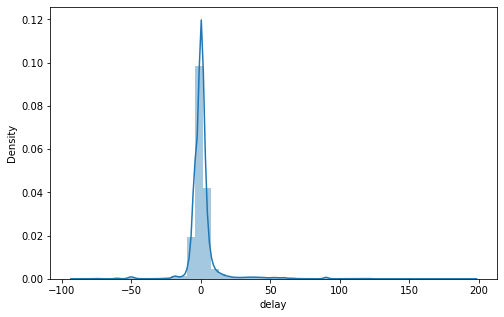

In [43]:
# Make a plot of the distribution of the numerical data in the dataset.
numerical_features_data = Train.select_dtypes(include = 'int64')
for every_feature in numerical_features_data:
  plt.figure(figsize = (8, 5))
  sns.distplot(Train[every_feature])

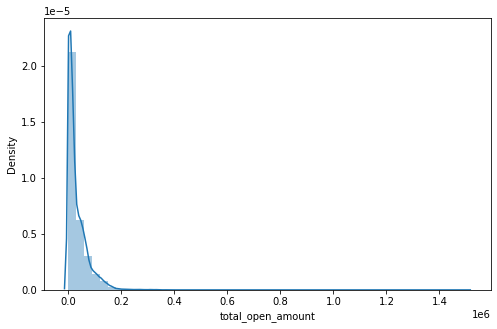

In [44]:
numerical_features_dataset = Train.select_dtypes(include ='float64')
for every_feature in numerical_features_dataset:
  plt.figure(figsize = (8, 5))
  sns.distplot(Train[every_feature])

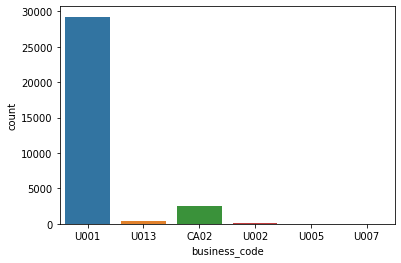

In [45]:
sns.countplot(x ='business_code', data = Train)

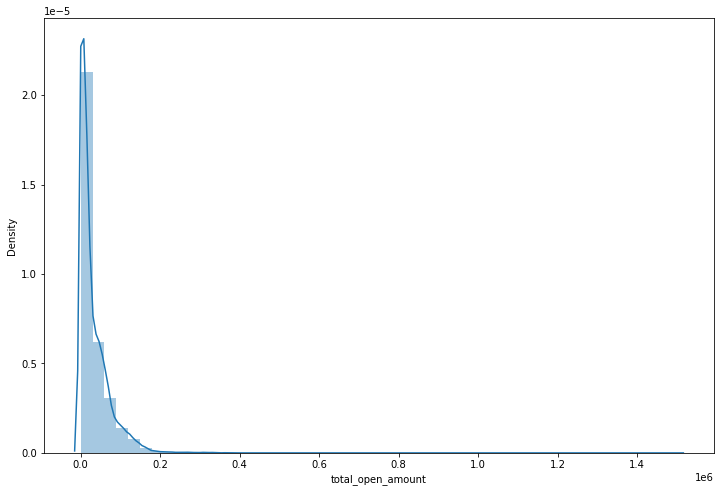

In [46]:
plt.figure(figsize = (12,8))
sns.distplot(Train['total_open_amount'], kde=True)

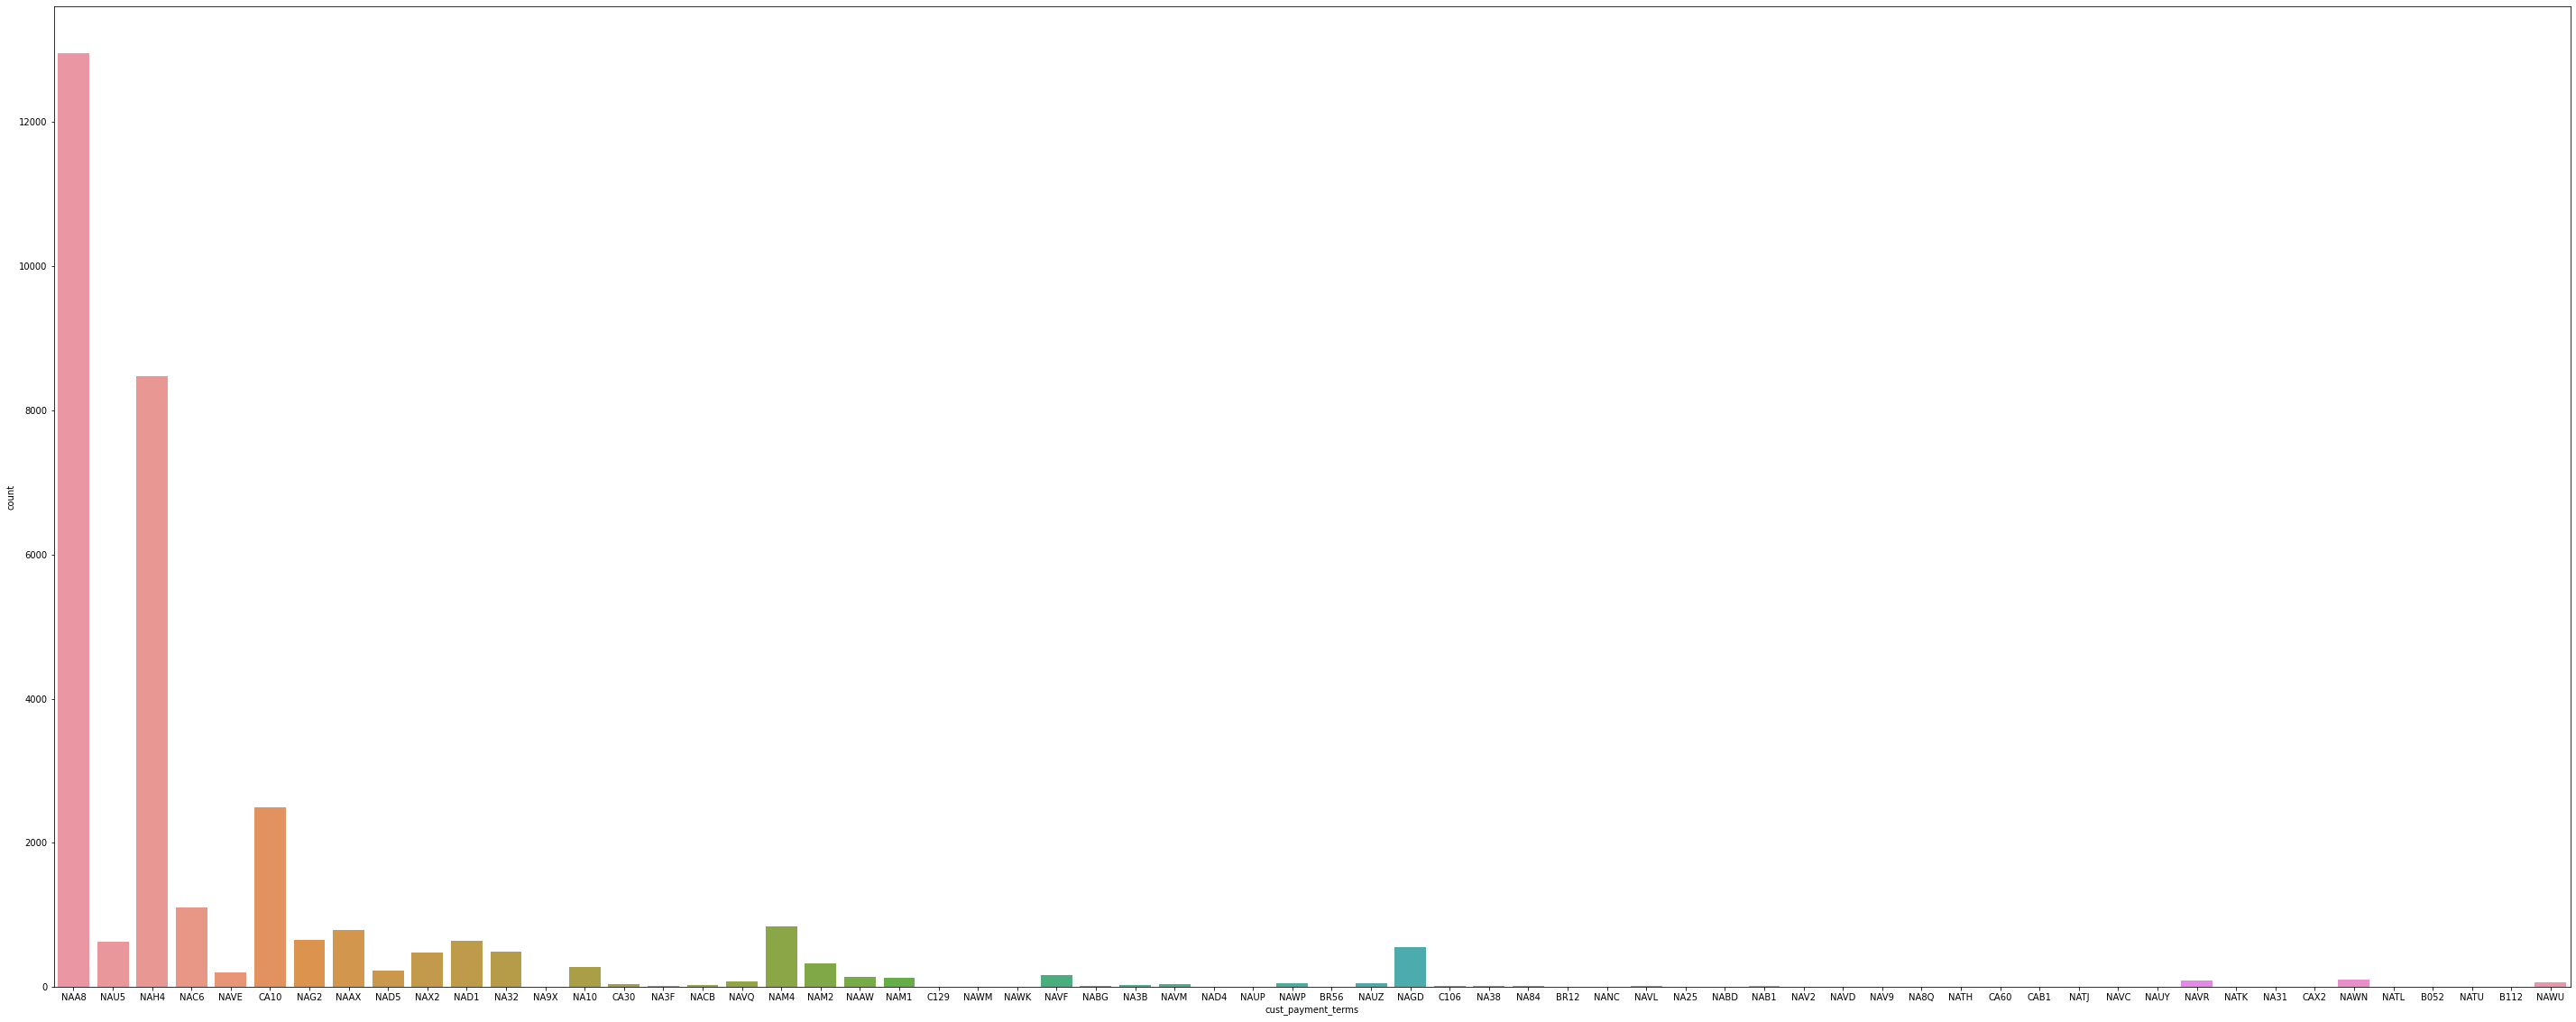

In [47]:
plt.figure(figsize = (50,20))
sns.countplot(x ='cust_payment_terms', data = Train)

##Feature Engineering

In [48]:
Train.head()

,business_code,cust_number,name_customer,clear_date,document_create_date.1,due_in_date,invoice_currency,total_open_amount,cust_payment_terms,delay
7293,U001,0200726979,BJ'S,2019-01-15,2018-12-30,2019-01-14,USD,42.04,NAA8,1
38373,U001,0200706844,WINC llc,2019-01-14,2018-12-30,2019-01-14,USD,14235.96,NAA8,0
1779,U001,0200772670,ASSOCIAT us,2019-01-14,2018-12-30,2019-01-14,USD,351.20,NAU5,0
16153,U001,0200769623,WAL-MAR llc,2019-01-09,2018-12-30,2019-01-14,USD,6145.65,NAH4,-5
14578,U001,0200769623,WAL-MAR corporation,2019-01-10,2018-12-30,2019-01-14,USD,8730.88,NAH4,-4


In [49]:
Train.nunique()

business_code                 6
cust_number                1324
name_customer              3636
clear_date                  287
document_create_date.1      283
due_in_date                 344
invoice_currency              2
total_open_amount         29491
cust_payment_terms           64
delay                       182
dtype: int64

In [50]:
# Binarization of invoice_currency column
Train['invoice_currency'] = Train.apply(lambda x: 1 if x['invoice_currency'] == 'USD' else 0, axis=1)
Val1['invoice_currency'] = Val1.apply(lambda x: 1 if x['invoice_currency'] == 'USD' else 0, axis=1)
Val2['invoice_currency'] = Val2.apply(lambda x: 1 if x['invoice_currency'] == 'USD' else 0, axis=1)

#### Frequency Encoding on "business_code"

In [51]:
# Frequency encoding for 'business_code' column
business_code_encoding = Train.groupby('business_code').size() / len(Train)

Train.loc[:, 'business_code'] = Train['business_code'].map(business_code_encoding)
Val1.loc[:, 'business_code'] = Val1['business_code'].map(business_code_encoding)
Val2.loc[:, 'business_code'] = Val2['business_code'].map(business_code_encoding)

In [52]:
Train.head()

,business_code,cust_number,name_customer,clear_date,document_create_date.1,due_in_date,invoice_currency,total_open_amount,cust_payment_terms,delay
7293,0.902962,0200726979,BJ'S,2019-01-15,2018-12-30,2019-01-14,1,42.04,NAA8,1
38373,0.902962,0200706844,WINC llc,2019-01-14,2018-12-30,2019-01-14,1,14235.96,NAA8,0
1779,0.902962,0200772670,ASSOCIAT us,2019-01-14,2018-12-30,2019-01-14,1,351.20,NAU5,0
16153,0.902962,0200769623,WAL-MAR llc,2019-01-09,2018-12-30,2019-01-14,1,6145.65,NAH4,-5
14578,0.902962,0200769623,WAL-MAR corporation,2019-01-10,2018-12-30,2019-01-14,1,8730.88,NAH4,-4


##### Creating new column "customer_avg_delay"

In [53]:
customer_avg_delay_mean = Train.groupby('cust_number')['delay'].mean()
Train['customer_avg_delay'] = Train.cust_number.map(customer_avg_delay_mean)
Val1['customer_avg_delay'] = Val1.cust_number.map(customer_avg_delay_mean)
Val1['customer_avg_delay'].fillna(Train['delay'].mean(), inplace=True)
Val2['customer_avg_delay'] = Val2.cust_number.map(customer_avg_delay_mean)
Val2['customer_avg_delay'].fillna(Train['delay'].mean(), inplace=True)

##### Creating new column 'create_due_difference' by subtracting 'due_in_date' with 'document_create_date.1'

In [54]:
Train['create_due_difference'] = (Train['due_in_date'] - Train['document_create_date.1']).dt.days
Val1['create_due_difference'] = (Val1['due_in_date'] - Val1['document_create_date.1']).dt.days
Val2['create_due_difference'] = (Val2['due_in_date'] - Val2['document_create_date.1']).dt.days

#### Target Encoding on "cust_payment_terms"

In [55]:
Train.head()

,business_code,cust_number,name_customer,clear_date,document_create_date.1,due_in_date,invoice_currency,total_open_amount,cust_payment_terms,delay,customer_avg_delay,create_due_difference
7293,0.902962,0200726979,BJ'S,2019-01-15,2018-12-30,2019-01-14,1,42.04,NAA8,1,0.969874,15
38373,0.902962,0200706844,WINC llc,2019-01-14,2018-12-30,2019-01-14,1,14235.96,NAA8,0,0.063197,15
1779,0.902962,0200772670,ASSOCIAT us,2019-01-14,2018-12-30,2019-01-14,1,351.20,NAU5,0,2.039152,15
16153,0.902962,0200769623,WAL-MAR llc,2019-01-09,2018-12-30,2019-01-14,1,6145.65,NAH4,-5,-2.027544,15
14578,0.902962,0200769623,WAL-MAR corporation,2019-01-10,2018-12-30,2019-01-14,1,8730.88,NAH4,-4,-2.027544,15


In [56]:
Train.cust_payment_terms.nunique()

64

#### Mean Encoding on "cust_payment_terms" and then scaling using min-max scaler

In [57]:
encoding_data = Train.groupby(['cust_payment_terms'])['delay'].mean().to_dict() 
Train['cust_payment_terms'] = Train['cust_payment_terms'].map(encoding_data)
Val1['cust_payment_terms'] = Val1['cust_payment_terms'].map(encoding_data)
Val1['cust_payment_terms'].fillna(Train['delay'].mean(), inplace = True)
Val2['cust_payment_terms'] = Val2['cust_payment_terms'].map(encoding_data)
Val2['cust_payment_terms'].fillna(Train['delay'].mean(), inplace = True)

Train['cust_payment_terms'] = MinMaxScaler().fit_transform(np.array(Train['cust_payment_terms']).reshape(-1,1))
Val1['cust_payment_terms'] = MinMaxScaler().fit_transform(np.array(Val1['cust_payment_terms']).reshape(-1,1))
Val2['cust_payment_terms'] = MinMaxScaler().fit_transform(np.array(Val2['cust_payment_terms']).reshape(-1,1))



#### Extracting week, month, year and quarter from "due_in_date"


In [58]:
# Extracting week, month, year and quarter from "due_in_date"
Train['due_Month'] = Train['due_in_date'].dt.month
Train['due_Quarter'] = Train['due_in_date'].dt.quarter
Train['due_Week'] = Train['due_in_date'].dt.week

Train.drop('due_in_date', axis = 1, inplace = True)

In [59]:
# Extracting week, month, year and quarter from "due_in_date"

Val1['due_Month'] = Val1['due_in_date'].dt.month
Val1['due_Quarter'] = Val1['due_in_date'].dt.quarter
Val1['due_Week'] = Val1['due_in_date'].dt.week

Val1.drop('due_in_date', axis=1, inplace=True)

In [60]:
# Extracting week, month, year and quarter from "due_in_date"

Val2['due_Month'] = Val2['due_in_date'].dt.month
Val2['due_Quarter'] = Val2['due_in_date'].dt.quarter
Val2['due_Week'] = Val2['due_in_date'].dt.week

Val2.drop('due_in_date', axis=1, inplace=True)

####Creating new column "monthly_avg_delay"


In [61]:
due_month_average_delay = Train.groupby('due_Month')['delay'].mean()
Train['month_avg_delay'] = Train.due_Month.map(due_month_average_delay)
Val1['month_avg_delay'] = Val1.due_Month.map(due_month_average_delay)
Val2['month_avg_delay'] = Val2.due_Month.map(due_month_average_delay)

#### Visualization plots

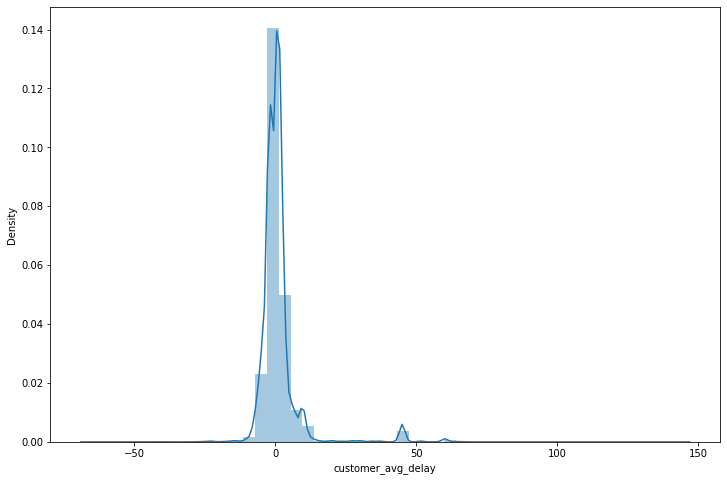

In [62]:
plt.figure(figsize = (12,8))
sns.distplot(Train['customer_avg_delay'], kde = True)

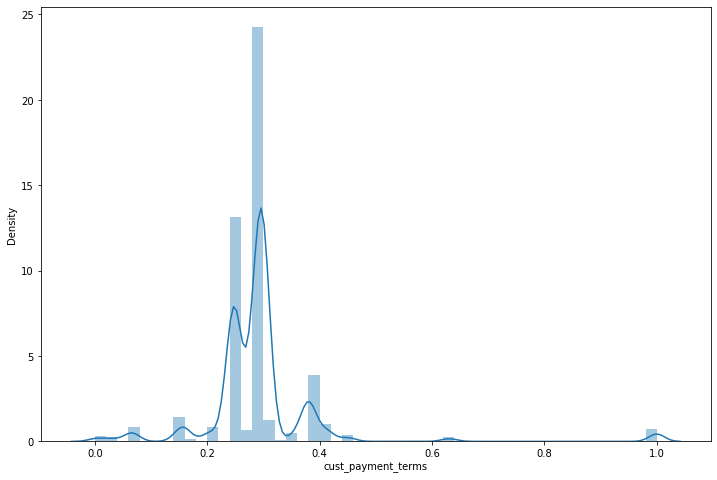

In [63]:
plt.figure(figsize = (12, 8))
sns.distplot(Train['cust_payment_terms'], kde = True)

#### Heatmap

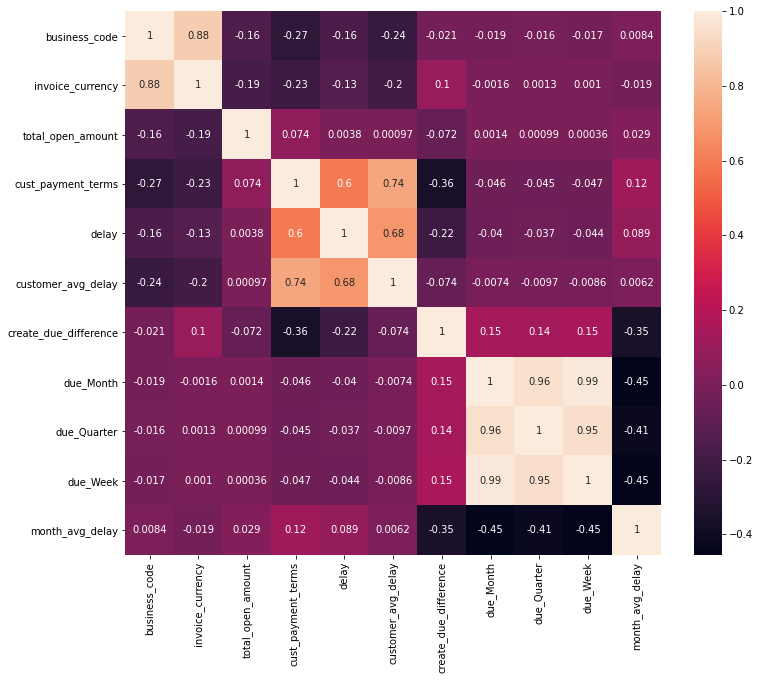

In [64]:
# visualising the correlation matrix
plt.figure(figsize = (12, 10))
sns.heatmap(Train.corr(), annot=True)

In [65]:
# dropping the columns and taking only the required ones
x_train = Train.drop(['cust_number', 'name_customer', 'clear_date', 'delay', 'document_create_date.1'], axis=1)
x_val1 = Val1.drop(['cust_number', 'name_customer', 'clear_date', 'delay', 'document_create_date.1'], axis=1)
x_val2 = Val2.drop(['cust_number', 'name_customer', 'clear_date', 'delay', 'document_create_date.1'], axis=1)

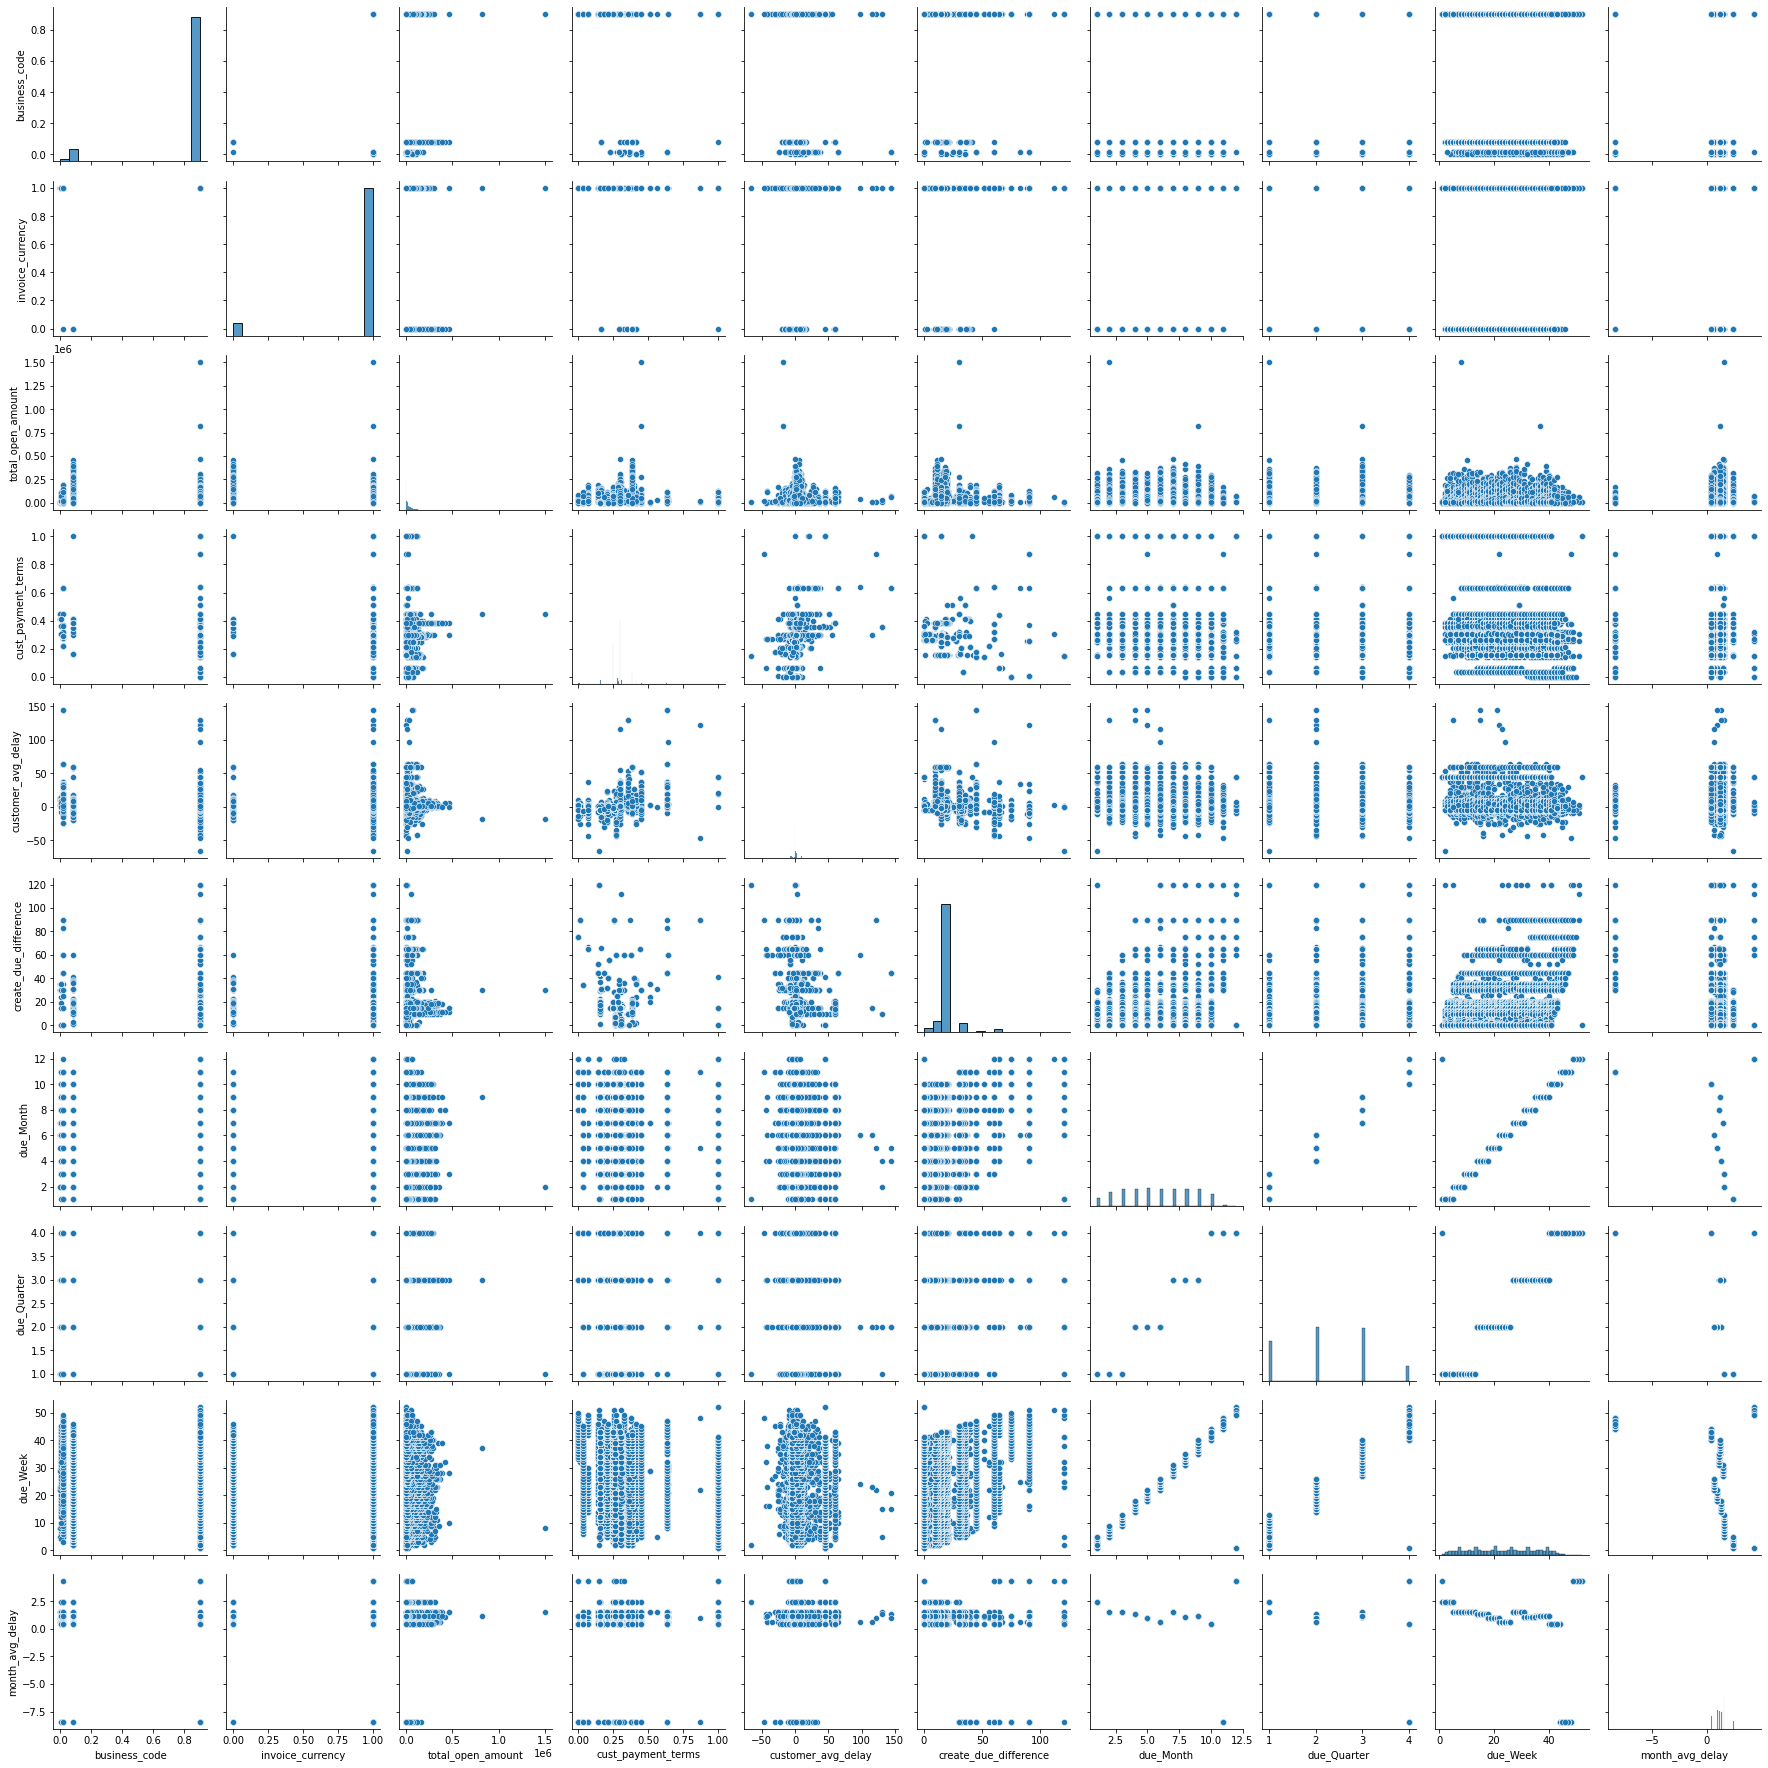

In [66]:
sns.pairplot(x_train)

In [67]:
# list of the features used
features_used = list(x_train.columns)
features_used

['business_code',
 'invoice_currency',
 'total_open_amount',
 'cust_payment_terms',
 'customer_avg_delay',
 'create_due_difference',
 'due_Month',
 'due_Quarter',
 'due_Week',
 'month_avg_delay']

###Linear Regression

In [68]:
Lreg = LinearRegression()
Lreg.fit(x_train, y_train) # fitting the data

pred_train = Lreg.predict(x_train)
rmse_train = mean_squared_error(y_train, pred_train) ** 0.5
print('\nRMSE on Train dataset : ', rmse_train)

pred_val1 = Lreg.predict(x_val1)
rmse_val1 = mean_squared_error(y_val1, pred_val1) ** 0.5
print('\nRMSE on val1 dataset : ', rmse_val1)

pred_val2 = Lreg.predict(x_val2)
rmse_val2 = mean_squared_error(y_val2, pred_val2) ** 0.5
print('\nRMSE on val2 dataset : ', rmse_val2)


RMSE on Train dataset :  8.231005554338058

RMSE on val1 dataset :  5.558242461053472

RMSE on val2 dataset :  7.6843313128162745


### Ridge Regression


In [69]:
rr = Ridge(alpha = 100)
rr.fit(x_train, y_train)

pred_train_rr = rr.predict(x_train)
rmse_val1_rr = mean_squared_error(y_train, pred_train_rr) ** 0.5
print('\nRidge-RMSE on train dataset : ', rmse_val1_rr)

pred_val1_rr = rr.predict(x_val1)
rmse_val1_rr = mean_squared_error(y_val1, pred_val1_rr) ** 0.5
print('\nRidge-RMSE on val1 dataset : ', rmse_val1_rr)

pred_val2_rr = rr.predict(x_val2)
rmse_val2_rr = mean_squared_error(y_val2, pred_val2_rr) ** 0.5
print('\nRidge-RMSE on val2 dataset : ', rmse_val2_rr)


Ridge-RMSE on train dataset :  8.236144519151235

Ridge-RMSE on val1 dataset :  5.547877270734953

Ridge-RMSE on val2 dataset :  7.709553291286232


### Dealing in Test Data

In [70]:
test.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,document_create_date.1,due_in_date,invoice_currency,total_open_amount,cust_payment_terms,invoice_id,isOpen
46387,U001,0200803720,DEC co,NaT,2020,2020-03-24,2020-04-08,USD,799.06,NAM4,1930685599,1
46388,U001,0100050364,SING foundation,NaT,2020,2020-04-15,2020-04-30,USD,21570.32,NAA8,1930788480,1
46389,U001,0200769623,WAL-MAR,NaT,2020,2020-03-30,2020-04-14,USD,24152.43,NAH4,1930718124,1
46390,U001,0200706844,WINC corporation,NaT,2020,2020-04-15,2020-04-30,USD,42289.33,NAA8,1930783316,1
46391,U001,0200769623,WAL-MAR in,NaT,2020,2020-03-01,2020-03-16,USD,19125.50,NAH4,1930584930,1


In [71]:
# dropping "business_year" and "invoice_id"
test.drop(['buisness_year', 'invoice_id'], axis = 1, inplace = True)

In [72]:
# Binarizing "invoice_currency" column
test['invoice_currency'] = test.apply(lambda x: 1 if x['invoice_currency'] == 'USD' else 0, axis = 1)

In [73]:
# Frequency Encoding on 'business_code'
test.loc[:, 'business_code'] = test['business_code'].map(business_code_encoding)

In [74]:
# Creating "cust_avg_delay" column
cust_avg_delay_mean = Train.groupby('cust_number')['delay'].mean()
test['cust_avg_delay'] = test.cust_number.map(cust_avg_delay_mean)
test['cust_avg_delay'].fillna(Train['delay'].mean(), inplace = True)

In [75]:
# Creating 'create_due_difference' column by subtracting 'due_in_date' with 'document_create_datest
test['create_due_difference'] = (test['due_in_date'] - test['document_create_date.1']).dt.days

In [76]:
#Mean Encoding on 'cust_payment_terms' and then using min-max scaler for scaling
test['cust_payment_terms'] = test['cust_payment_terms'].map(encoding_data)
test['cust_payment_terms'].fillna(Train['delay'].mean(), inplace = True)
test['cust_payment_terms'] = MinMaxScaler().fit_transform(np.array(test['cust_payment_terms']).reshape(-1,1))

In [77]:
# Extracting month, quarter, week from 'due_in_date' 
test['due_in_Month'] = test['due_in_date'].dt.month
test['due_in_Quarter'] = test['due_in_date'].dt.quarter
test['due_in_Week'] = test['due_in_date'].dt.week
#test.drop('due_in_date', axis = 1, inplace = True)

In [78]:
# Creating "monthly_avg_delay"
test['monthly_avg_delay'] = test.due_in_Month.map(due_month_average_delay)

In [79]:
# dropping the not so useful columns and keeping the required ones
x_test = test.drop(['cust_number', 'name_customer', 'clear_date', 'document_create_date.1', 'isOpen', 'due_in_date'], axis=1)

In [80]:
x_test.columns

Index(['business_code', 'invoice_currency', 'total_open_amount',
       'cust_payment_terms', 'cust_avg_delay', 'create_due_difference',
       'due_in_Month', 'due_in_Quarter', 'due_in_Week', 'monthly_avg_delay'],
      dtype='object')

In [81]:
x_test.dtypes

business_code            float64
invoice_currency           int64
total_open_amount        float64
cust_payment_terms       float64
cust_avg_delay           float64
create_due_difference      int64
due_in_Month               int64
due_in_Quarter             int64
due_in_Week                int64
monthly_avg_delay        float64
dtype: object

In [82]:
pred_test = Lreg.predict(x_test)
pred_test

array([-5.25211299,  0.48154191, -1.78900298, ..., -2.35972079,
        1.46743337,  3.1232617 ])

In [83]:
test['delay'] = np.floor(pred_test).astype(int)

In [84]:
test.head()

,business_code,cust_number,name_customer,clear_date,document_create_date.1,due_in_date,invoice_currency,total_open_amount,cust_payment_terms,isOpen,cust_avg_delay,create_due_difference,due_in_Month,due_in_Quarter,due_in_Week,monthly_avg_delay,delay
46387,0.902962,0200803720,DEC co,NaT,2020-03-24,2020-04-08,1,799.06,0.128331,1,-5.227468,15,4,2,15,1.334475,-6
46388,0.902962,0100050364,SING foundation,NaT,2020-04-15,2020-04-30,1,21570.32,0.273451,1,0.461538,15,4,2,18,1.334475,0
46389,0.902962,0200769623,WAL-MAR,NaT,2020-03-30,2020-04-14,1,24152.43,0.222049,1,-2.027544,15,4,2,16,1.334475,-2
46390,0.902962,0200706844,WINC corporation,NaT,2020-04-15,2020-04-30,1,42289.33,0.273451,1,0.063197,15,4,2,18,1.334475,0
46391,0.902962,0200769623,WAL-MAR in,NaT,2020-03-01,2020-03-16,1,19125.50,0.222049,1,-2.027544,15,3,1,12,1.561082,-3


In [86]:
from datetime import timedelta
test['clear_date'] = test.apply(lambda x: x['due_in_date'] + timedelta(x['delay']), axis=1)

In [ ]:
test.head(3)

In [87]:
def bucketization(delay):
    if delay <= 15:
        bucket = '0-15 days'
    elif delay in range(16,31):
        bucket = '16-30 days'
    elif delay in range(31,46):
        bucket = '31-45 days'
    elif delay in range(46,61):
        bucket = '46-60 days'
    else:
        bucket = 'Greater than 60'
    return bucket

In [88]:
test['Aging_Bucket'] = test['delay'].apply(bucketization) 

In [89]:
test.head()

,business_code,cust_number,name_customer,clear_date,document_create_date.1,due_in_date,invoice_currency,total_open_amount,cust_payment_terms,isOpen,cust_avg_delay,create_due_difference,due_in_Month,due_in_Quarter,due_in_Week,monthly_avg_delay,delay,Aging_Bucket
46387,0.902962,0200803720,DEC co,2020-04-02,2020-03-24,2020-04-08,1,799.06,0.128331,1,-5.227468,15,4,2,15,1.334475,-6,0-15 days
46388,0.902962,0100050364,SING foundation,2020-04-30,2020-04-15,2020-04-30,1,21570.32,0.273451,1,0.461538,15,4,2,18,1.334475,0,0-15 days
46389,0.902962,0200769623,WAL-MAR,2020-04-12,2020-03-30,2020-04-14,1,24152.43,0.222049,1,-2.027544,15,4,2,16,1.334475,-2,0-15 days
46390,0.902962,0200706844,WINC corporation,2020-04-30,2020-04-15,2020-04-30,1,42289.33,0.273451,1,0.063197,15,4,2,18,1.334475,0,0-15 days
46391,0.902962,0200769623,WAL-MAR in,2020-03-13,2020-03-01,2020-03-16,1,19125.50,0.222049,1,-2.027544,15,3,1,12,1.561082,-3,0-15 days
